In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from tinygrad import Tensor, nn, TinyJit
from common import word_generator

In [3]:
names = open("./names.txt").read().splitlines()

In [4]:
empty_char_token = "."
vocab = [empty_char_token] + sorted(set("".join(names)))
vocab_size = len(vocab)

In [5]:
block_size = 16
X, y = [], []

for name in names:
  name_chars = [empty_char_token] * block_size + list(name) + [empty_char_token]
  for i in range(len(name_chars) - block_size):
    X.append([vocab.index(char) for char in name_chars[i : i + block_size]])
    y.append(vocab.index(name_chars[i + block_size]))


split = int(0.8 * len(X))
X_train, y_train, X_test, y_test = (
  Tensor(X[:split]),
  Tensor(y[:split]),
  Tensor(X[split:]),
  Tensor(y[split:]),
)

X_train, y_train, X_test, y_test

(<Tensor <LB CLANG (182516, 16) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (182516,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630, 16) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>,
 <Tensor <LB CLANG (45630,) int (<MetaOps.COPY: 3>, None)> on CLANG with grad None>)

In [6]:
class WaveNet:
  def __init__(
    self,
    vocab_size: int,
    embed_size: int,
    input_size: int,
    output_size: int,
  ):
    assert 0 < input_size <= 16
    group_size = 2
    groups = math.log(input_size, group_size)
    assert groups.is_integer()
    groups = int(groups)
    self.input_size = input_size

    def group_time_dim(x: Tensor):
      assert len(x.shape) == 3
      B, T, C = x.shape
      assert T % group_size == 0
      return x.reshape(B, T // group_size, group_size * C).squeeze(1)

    self.layers = []

    self.layers.append(nn.Embedding(vocab_size, embed_size))
    self.layers.append(group_time_dim)
    groups -= 1

    prev_layer_size = embed_size * group_size
    for h in [200, 100, 50][:groups]:
      self.layers.append(nn.Linear(prev_layer_size, h))
      self.layers.append(Tensor.tanh)
      self.layers.append(group_time_dim)
      prev_layer_size = h * group_size

    self.layers.append(nn.Linear(prev_layer_size, output_size))

  def __call__(self, x: Tensor):
    assert len(x.shape) == 2 and x.shape[1] == self.input_size
    return x.sequential(self.layers)


wavenet = WaveNet(
  vocab_size, embed_size=10, input_size=block_size, output_size=vocab_size
)

In [7]:
sum(p.numel() for p in nn.state.get_parameters(wavenet))

57347

In [8]:
optim = nn.optim.Adam(nn.state.get_parameters(wavenet))
batch_size = 128


@TinyJit
@Tensor.train()
def train_step():
  optim.zero_grad()
  samples = Tensor.randint(batch_size, high=X_train.shape[0])
  X_samples, y_samples = X_train[samples], y_train[samples]
  loss = wavenet(X_samples).sparse_categorical_crossentropy(y_samples).backward()
  optim.step()
  return loss

In [9]:
losses = []
for step in range(1, 20001):
  loss = train_step().item()
  losses.append(loss)
  if step == 1 or step % 1000 == 0:
    with Tensor.inference_mode():
      acc = (wavenet(X_test).argmax(axis=1) == y_test).mean().item()
      print(f"step {step}, loss {loss:.2f}, acc {acc*100.:.2f}%")

step 1, loss 3.31, acc 12.34%
step 1000, loss 2.22, acc 27.94%
step 2000, loss 2.06, acc 28.24%
step 3000, loss 2.29, acc 29.40%
step 4000, loss 2.21, acc 29.07%
step 5000, loss 2.21, acc 29.77%
step 6000, loss 2.09, acc 30.07%
step 7000, loss 2.02, acc 29.87%
step 8000, loss 1.95, acc 29.95%
step 9000, loss 2.02, acc 30.49%
step 10000, loss 1.95, acc 30.33%
step 11000, loss 1.92, acc 29.89%
step 12000, loss 1.96, acc 30.36%
step 13000, loss 2.07, acc 30.56%
step 14000, loss 2.03, acc 30.61%
step 15000, loss 2.03, acc 30.80%
step 16000, loss 1.97, acc 30.87%
step 17000, loss 2.09, acc 30.31%
step 18000, loss 1.77, acc 30.95%
step 19000, loss 1.75, acc 30.99%
step 20000, loss 1.96, acc 31.26%


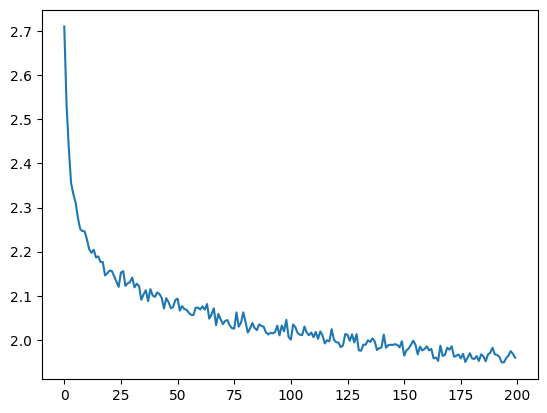

In [13]:
plt.plot(Tensor(losses).reshape(-1, 100).mean(1).numpy());

In [14]:
@word_generator(
  block_size=block_size, empty_char=empty_char_token, max_size=float("inf")
)
def generate_word(prev_block: str):
  with Tensor.inference_mode():
    x = Tensor([[vocab.index(char) for char in prev_block]])
    y = wavenet(x).squeeze()
    counts = y.exp()
    p = counts / counts.sum()
    return np.random.choice(a=vocab, p=p.numpy())

In [12]:
for _ in range(1000):
  print(generate_word())

jana
zhad
darria
khon
caelen
achron
betrator
kamier
sarae
carli
kaileen
leighlee
erinavon
ramlee
safimah
blayden
alisan
ahhitah
nehadatha
khastin
aura
kaelah
wallea
hoyson
zyppe
xildabets
selak
ahyley
taleen
ayslea
filfany
jahnamina
garmer
avain
macaliz
rasho
zylah
myreh
yoneston
kertan
semnan
kyriev
jaccor
poneska
yannali
nahi
atrisn
khalin
meloni
maleen
xiani
nadabel
elioston
yeline
eise
starrell
annalee
sohan
naras
emmalimah
natalay
armoni
kathlei
kair
andika
payda
myazsli
syougn
alexsello
emmelo
naqiani
inny
zeaci
taleer
subada
monathlyn
monu
lorast
decylys
faeda
beavla
edrin
darim
kati
sonino
royah
annaleen
avari
couh
mayislee
tyllos
blustie
raas
kada
naviah
isza
hadalis
anirah
talllies
chyra
kelson
mhorlee
kanni
jaelani
deleine
cherlanie
gizya
pertell
alexa
darran
lujarnelle
ancelynn
mostel
danterd
key
kora
emmalerleigh
yerty
niettaan
dalyn
kennin
laven
kaizy
aleiah
taniyah
saydia
navon
pormanie
iriya
avla
valynd
kgluelher
elliettn
anuzah
siflyn
diandy
trey
kamarion
chamanue
raki